## Imports

In [93]:
import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import missingno as msno


import sys

# Set all seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
RANDOM_STATE = 42

In [126]:

sys.path.append("../src")
from neural_networks.utils import calculate_historical_volatility, calculate_metrics, plot_predictions_vs_actual, create_sliding_window_dataset, split_data, prepare_time_series_data, evaluate_and_visualize_model, add_technical_indicators, add_predictive_features, add_volatility_features, select_features_with_rfecv, create_lstm_tuned_model, create_gru_model

In [ ]:
df=pd.read_csv("../data_macro.csv")


In [96]:
df.head()

,date,eurusd_close,eurusd_open,eurusd_high,eurusd_low,sp500,euro_stoxx_600,dax,SOFR,ester,BEIR_10Y_US,BEIR_10Y_EU,DGS10,DGS3MO,EURO_IR_3MO,EURO_IR_10Y
0,2018-04-03,1.229271,1.229332,1.233700,1.225505,2614.449951,369.070007,12002.450195,1.83,-0.452,2.08,1.518,2.79,1.75,-0.660035,0.552061
1,2018-04-04,1.227853,1.227943,1.231057,1.225761,2644.689941,367.329987,11957.900391,1.74,-0.454,2.08,1.511,2.79,1.71,-0.664585,0.547333
2,2018-04-05,1.228682,1.228788,1.229105,1.221941,2662.840088,376.130005,12305.190430,1.75,-0.453,2.08,1.509,2.83,1.72,-0.659658,0.570174
3,2018-04-06,1.225160,1.225100,1.228003,1.221807,2604.469971,374.820007,12241.269531,1.75,-0.453,2.07,1.510,2.77,1.73,-0.664742,0.559924
4,2018-04-09,1.227144,1.227144,1.233046,1.226257,2613.159912,375.299988,12261.750000,1.75,-0.453,2.07,1.508,2.78,1.76,-0.657340,0.561172


<Axes: >

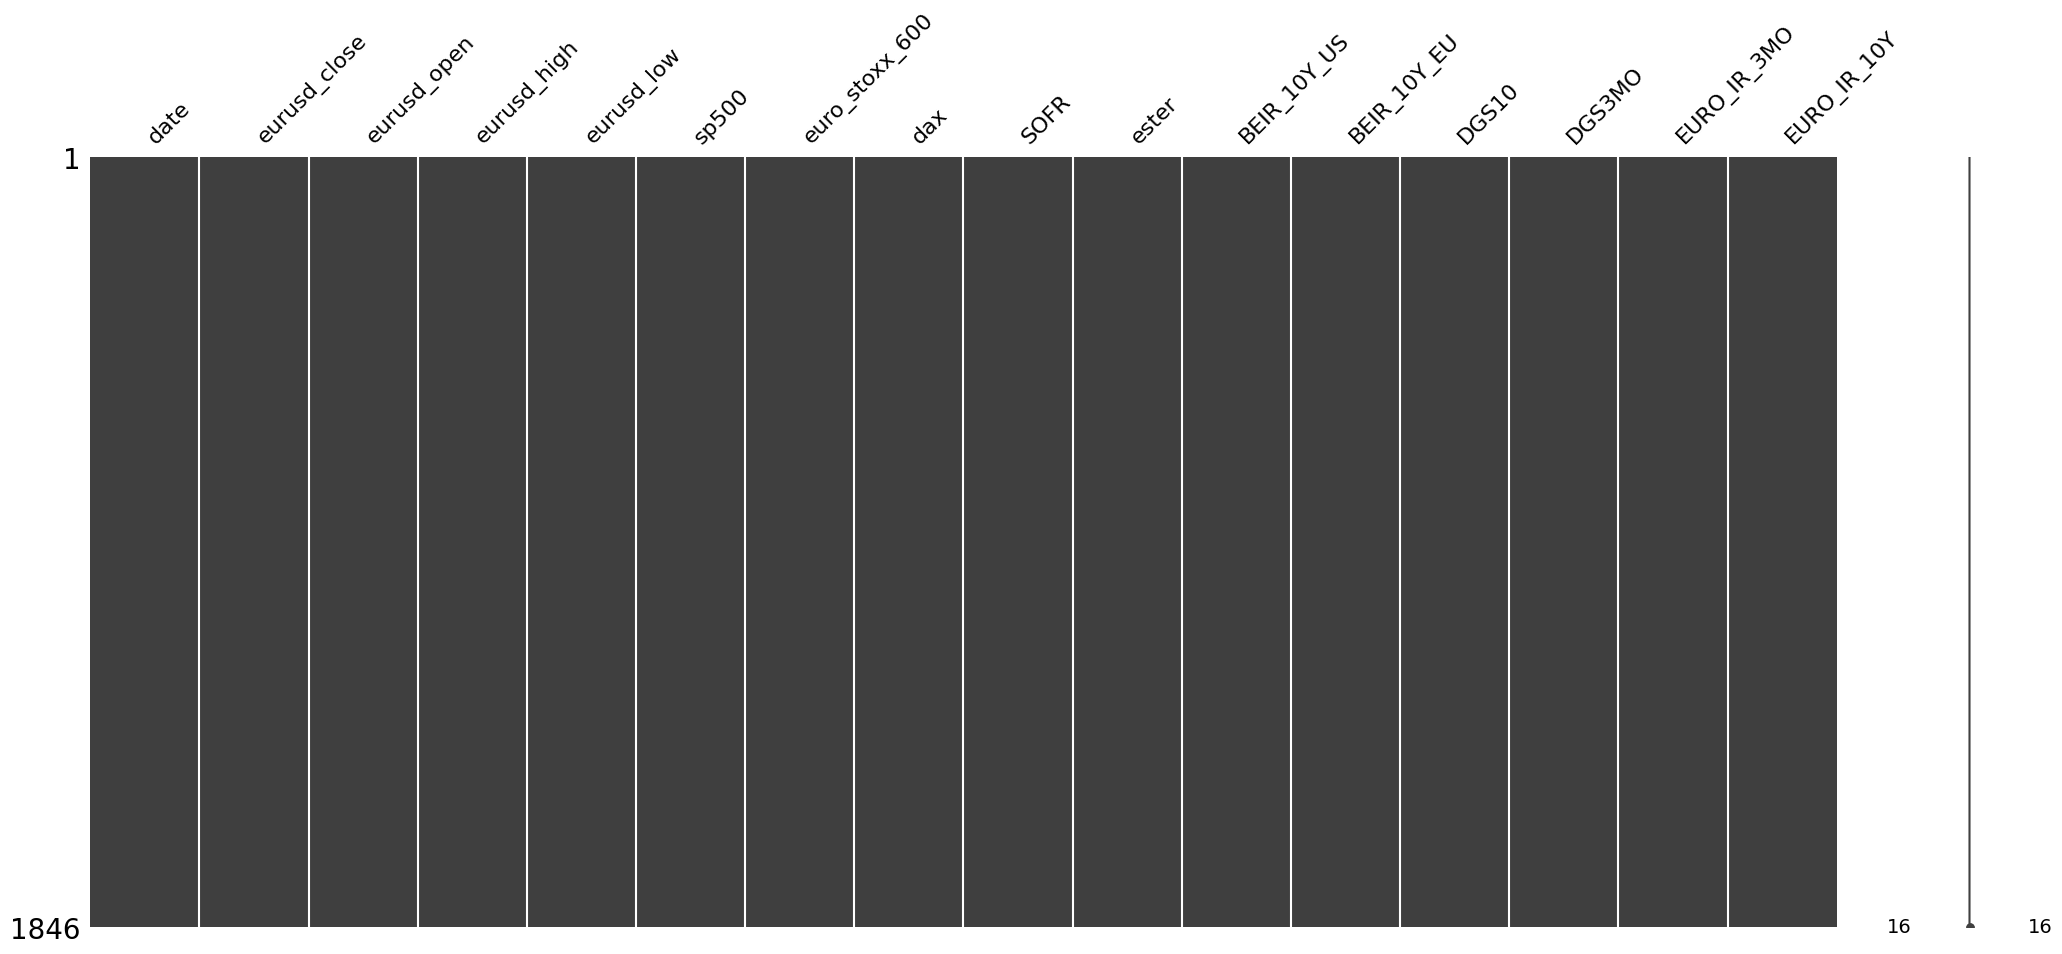

In [97]:
msno.matrix(df)

## Data preprocessing

In [98]:
import numpy as np

df['return_eurousd'] = np.log(df['eurusd_close'] / df['eurusd_close'].shift(1))
df['return_sp500'] = np.log(df['sp500'] / df['sp500'].shift(1))
df['return_dax'] = np.log(df['dax'] / df['dax'].shift(1))

df["Spread_rate"]=df["ester"]-df["SOFR"]
df["Spread_inflation"]=df["BEIR_10Y_EU"]-df["BEIR_10Y_US"]

df['return_sofr'] = df['SOFR'].pct_change() 
df['return_ester'] = df['ester'].pct_change()
df['return_BEIR_10Y_US'] = df['BEIR_10Y_US'].pct_change()
df['return_BEIR_10Y_EU'] = df['BEIR_10Y_EU'].pct_change()

df['return_DGS10'] = df['DGS10'].pct_change()
df['return_DGS3MO'] = df['DGS3MO'].pct_change()

df['return_EURO_IR_3MO'] = df['EURO_IR_3MO'].pct_change()
df['return_EURO_IR_10Y'] = df['EURO_IR_10Y'].pct_change()


df["return_Spread_rate"] = df["Spread_rate"].pct_change()
df["return_Spread_inflation"] = df["Spread_inflation"].pct_change()



<Axes: >

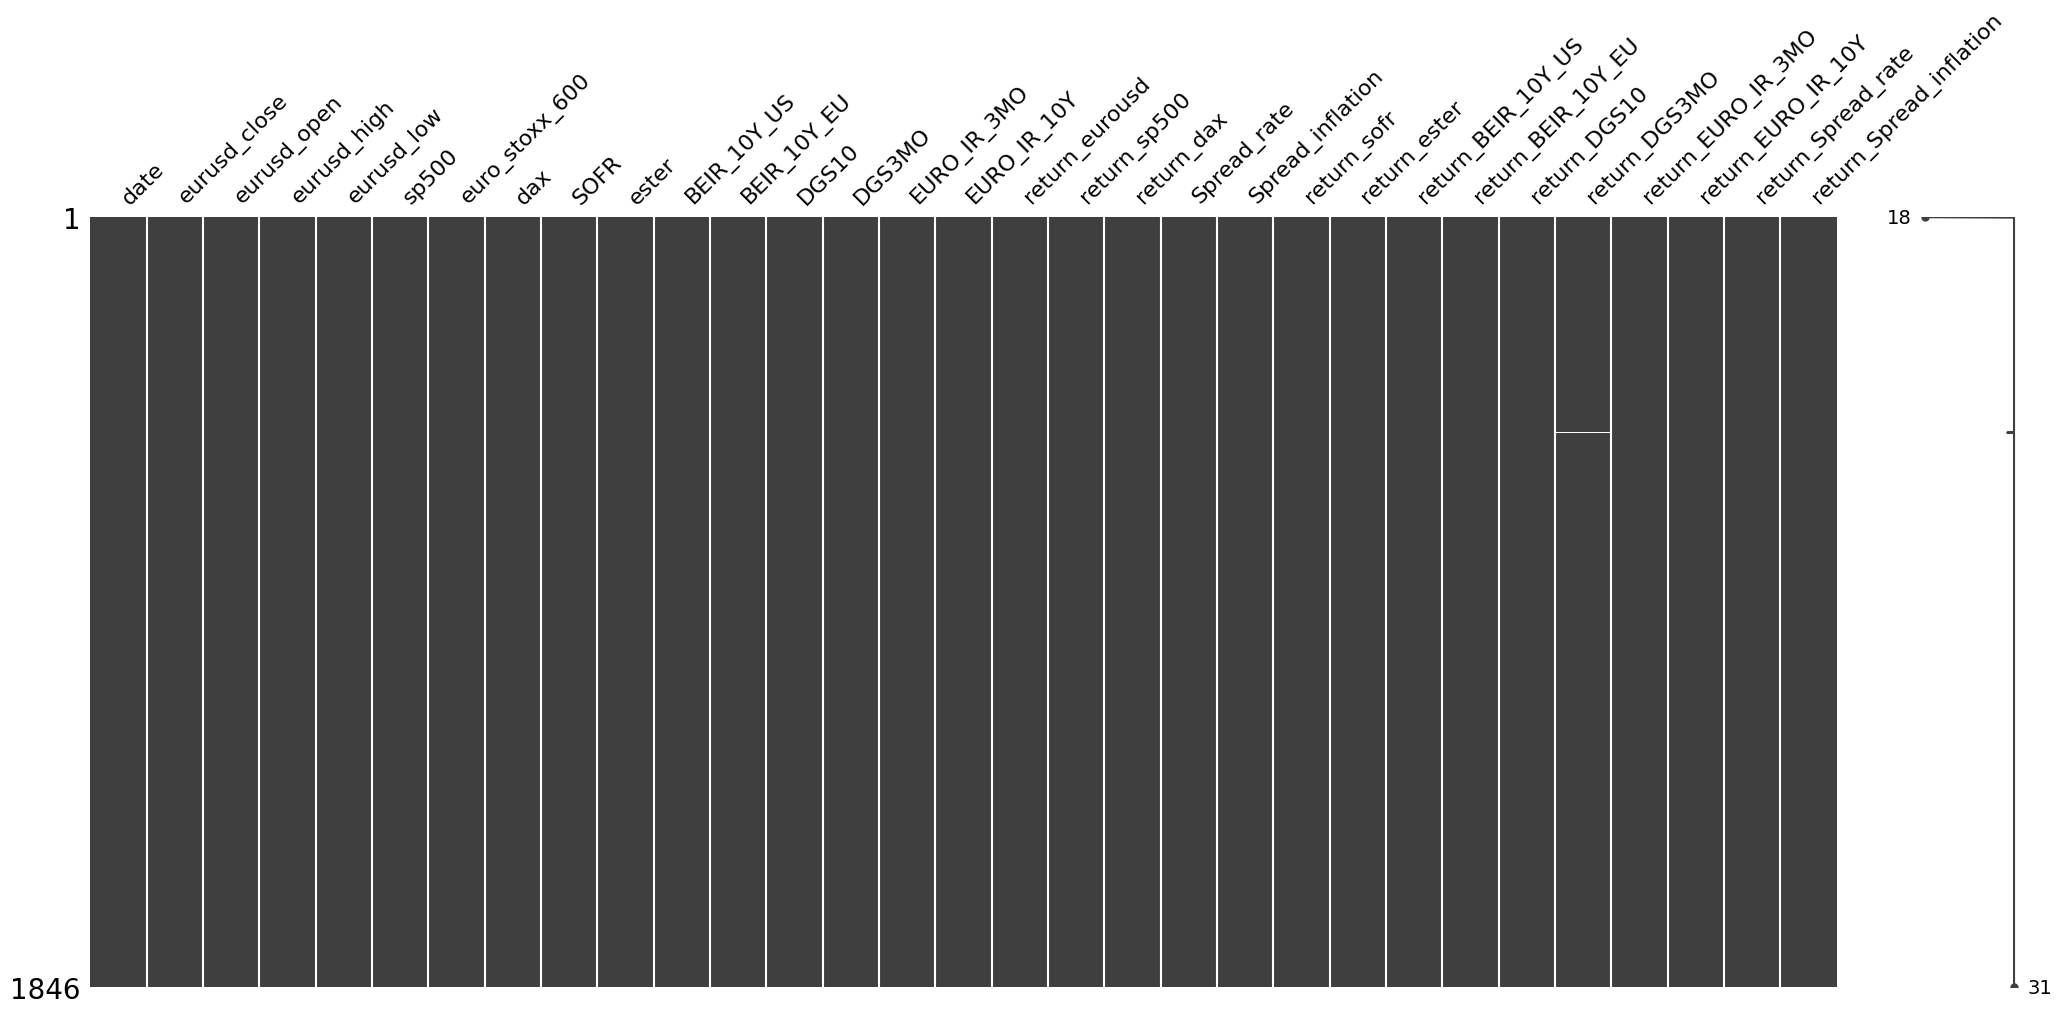

In [99]:
msno.matrix(df)

In [100]:
df = df.fillna(method='ffill')
df = df.dropna()

In [101]:
df["date"] = pd.to_datetime(df['date'])

In [ ]:
# Return data already calculated
returns = df['return_eurousd']

# Calculate historical volatility
hv = calculate_historical_volatility(returns)
df['historical_volatility'] = hv

df.head()

,date,eurusd_close,eurusd_open,eurusd_high,eurusd_low,sp500,euro_stoxx_600,dax,SOFR,ester,...,return_ester,return_BEIR_10Y_US,return_BEIR_10Y_EU,return_DGS10,return_DGS3MO,return_EURO_IR_3MO,return_EURO_IR_10Y,return_Spread_rate,return_Spread_inflation,historical_volatility
1,2018-04-04,1.227853,1.227943,1.231057,1.225761,2644.689941,367.329987,11957.900391,1.74,-0.454,...,0.004425,0.000000,-0.004611,0.000000,-0.022857,0.006894,-0.008564,-0.038563,1.245552e-02,NaN
2,2018-04-05,1.228682,1.228788,1.229105,1.221941,2662.840088,376.130005,12305.190430,1.75,-0.453,...,-0.002203,0.000000,-0.001324,0.014337,0.005848,-0.007414,0.041731,0.004102,3.514938e-03,NaN
3,2018-04-06,1.225160,1.225100,1.228003,1.221807,2604.469971,374.820007,12241.269531,1.75,-0.453,...,0.000000,-0.004808,0.000663,-0.021201,0.005814,0.007707,-0.017977,0.000000,-1.926445e-02,NaN
4,2018-04-09,1.227144,1.227144,1.233046,1.226257,2613.159912,375.299988,12261.750000,1.75,-0.453,...,0.000000,0.000000,-0.001325,0.003610,0.017341,-0.011135,0.002229,0.000000,3.571429e-03,NaN
5,2018-04-10,1.232240,1.232225,1.237777,1.230376,2656.870117,378.420013,12397.320312,1.75,-0.453,...,0.000000,0.004831,0.006631,0.007194,-0.011364,-0.007450,0.006353,0.000000,4.440892e-16,NaN


<Axes: >

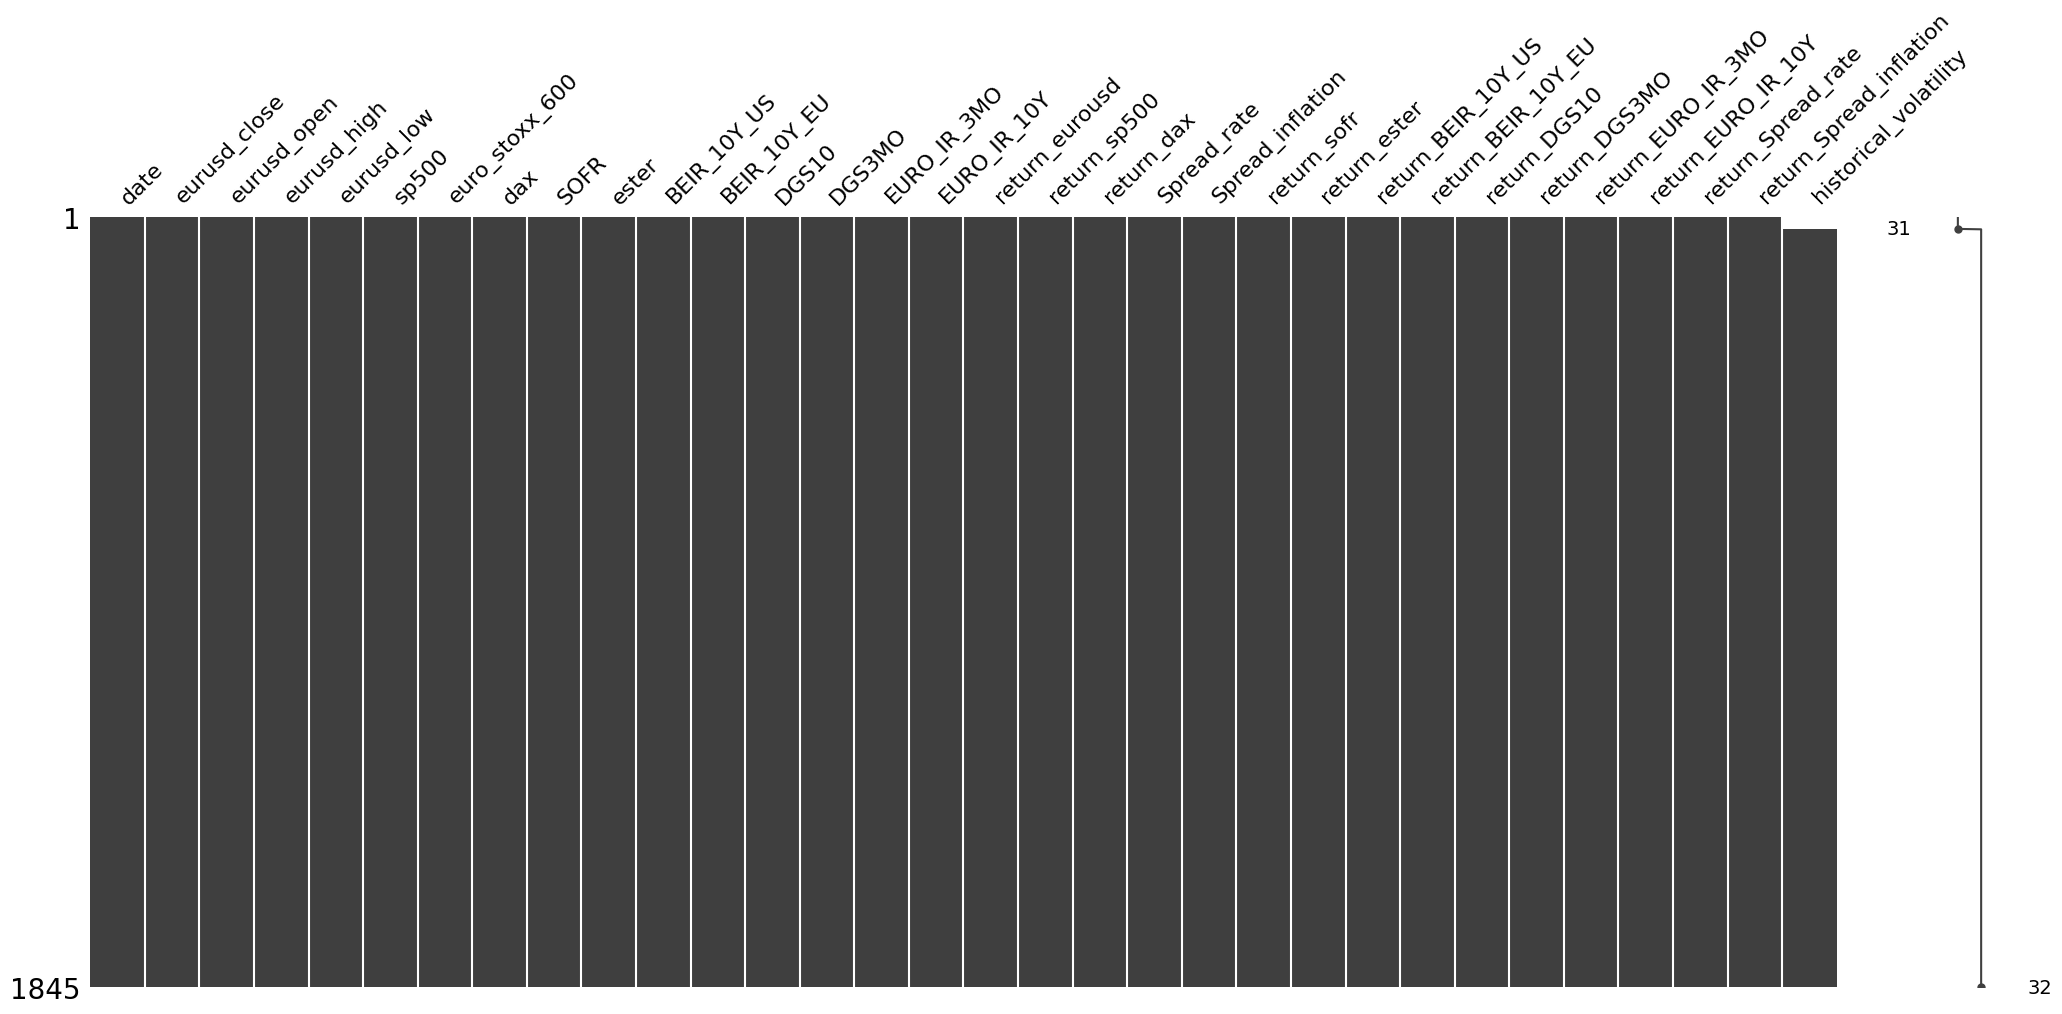

In [103]:
msno.matrix(df)

In [104]:
df = df.dropna()

## Integrating ARCH models predictions for the hybrid model

In [ ]:
# Add ARCH-based features
print("Adding GARCH features...")

df_with_garch = add_volatility_features(
    df,
    return_col='return_eurousd',
    window_size=30,
    stride=1,
    forecast_horizon=1
)
df_with_garch = df_with_garch.replace([np.inf, -np.inf], np.nan)


Adding GARCH features...
Traitement de t = 100/1816
Traitement de t = 200/1816
Traitement de t = 300/1816
Traitement de t = 400/1816
Traitement de t = 500/1816
Traitement de t = 600/1816
Traitement de t = 700/1816
Traitement de t = 800/1816
Traitement de t = 900/1816
Traitement de t = 1000/1816
Traitement de t = 1100/1816
Traitement de t = 1200/1816
Traitement de t = 1300/1816
Traitement de t = 1400/1816
Traitement de t = 1500/1816
Traitement de t = 1600/1816
Traitement de t = 1700/1816
Traitement de t = 1800/1816


<Axes: >

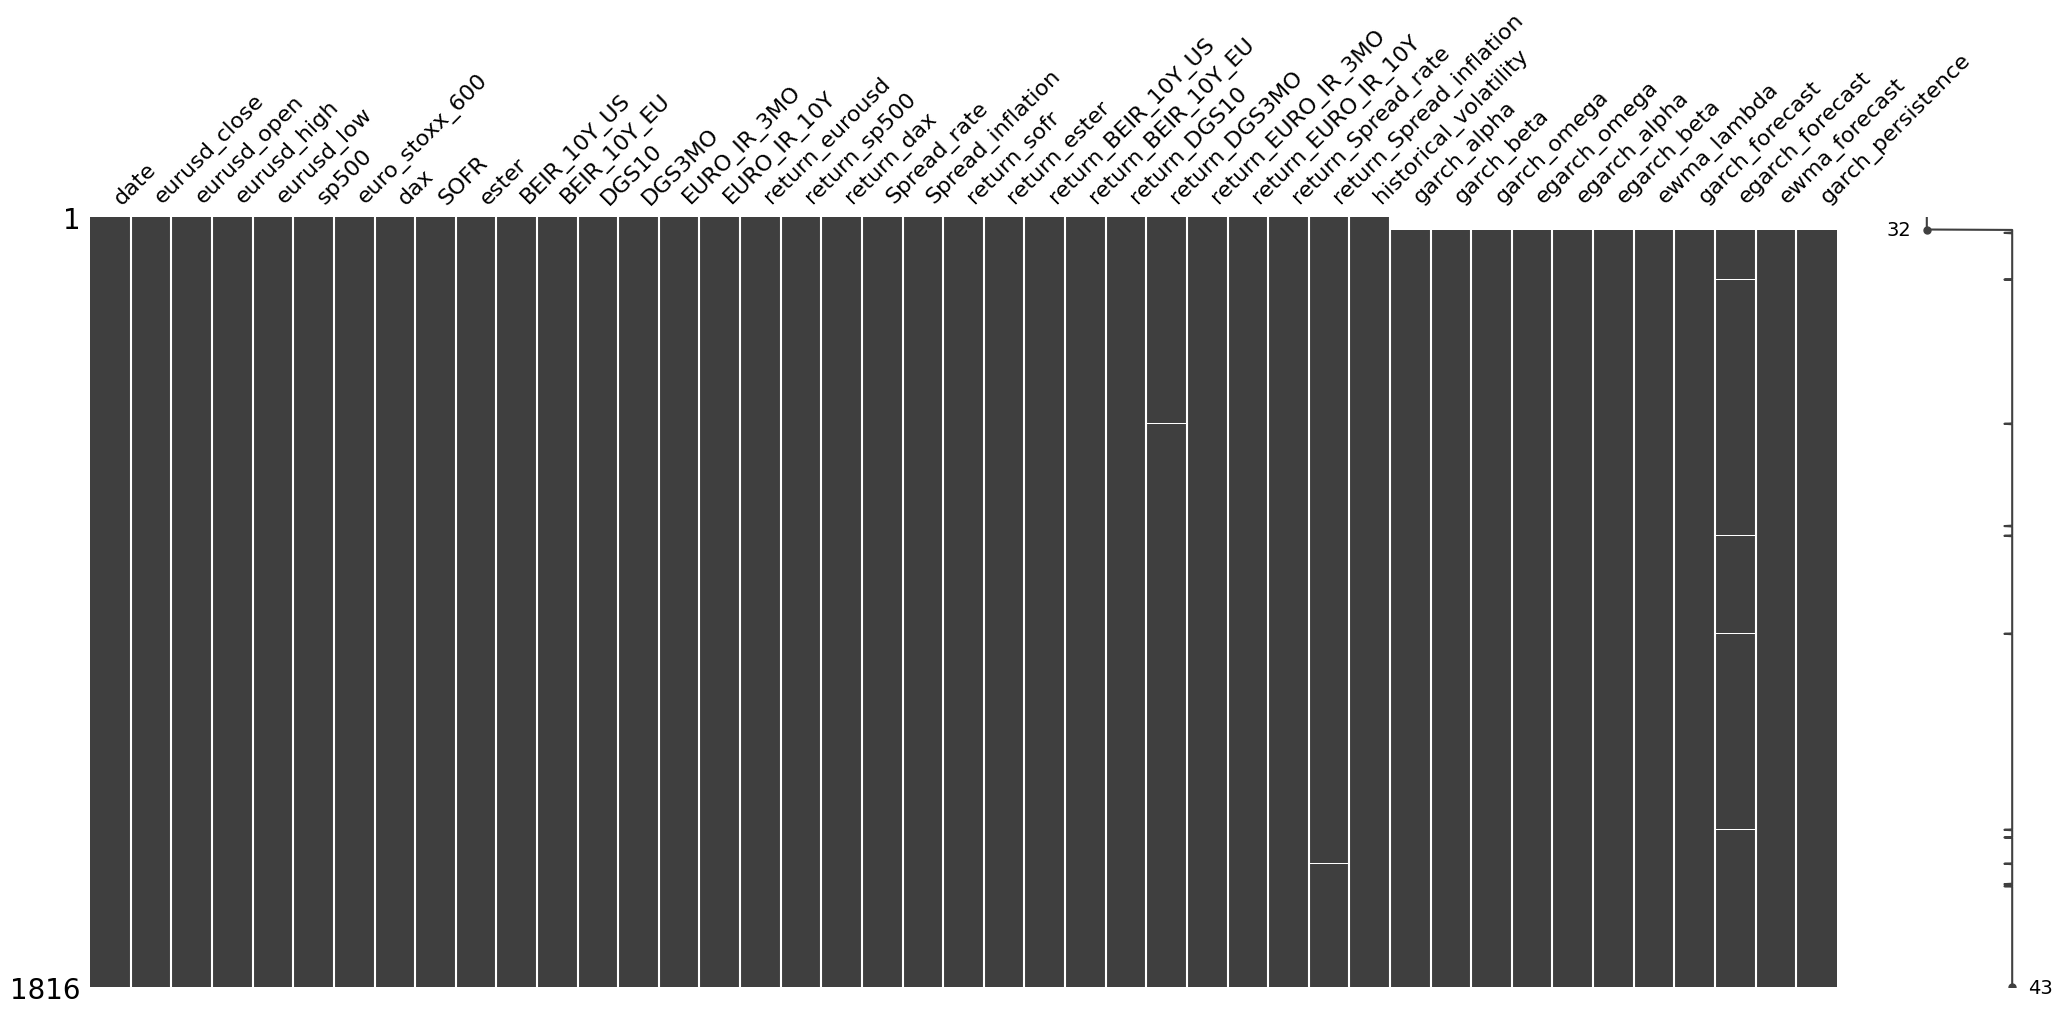

In [106]:
msno.matrix(df_with_garch)

In [107]:
df_with_garch = df_with_garch.fillna(method='ffill')
df_with_garch = df_with_garch.dropna()

## Feature engineering

In [108]:
df_enhanced = add_predictive_features(df_with_garch)

df_enhanced = df_enhanced.replace([np.inf, -np.inf], np.nan)

<Axes: >

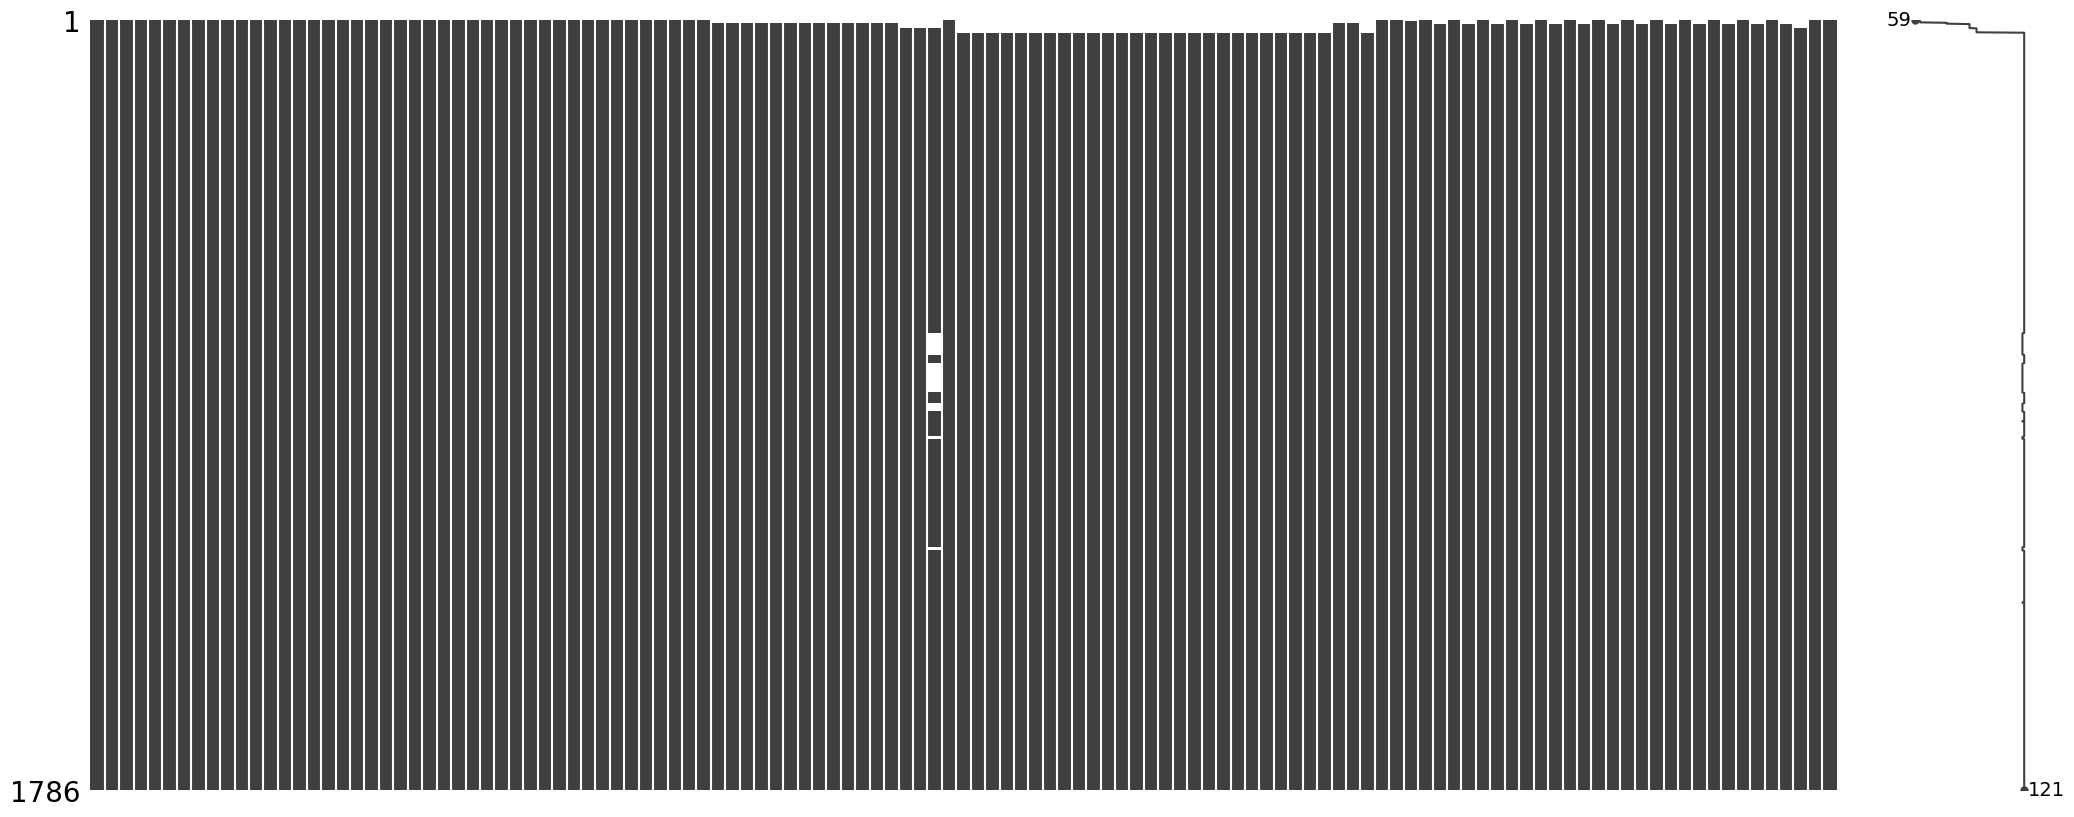

In [109]:
msno.matrix(df_enhanced)

In [110]:
df_enhanced = df_enhanced.fillna(method='ffill')
df_enhanced = df_enhanced.dropna()

In [111]:
df_technical = add_technical_indicators(df_enhanced, column='historical_volatility')

df_technical = df_technical.replace([np.inf, -np.inf], np.nan)

<Axes: >

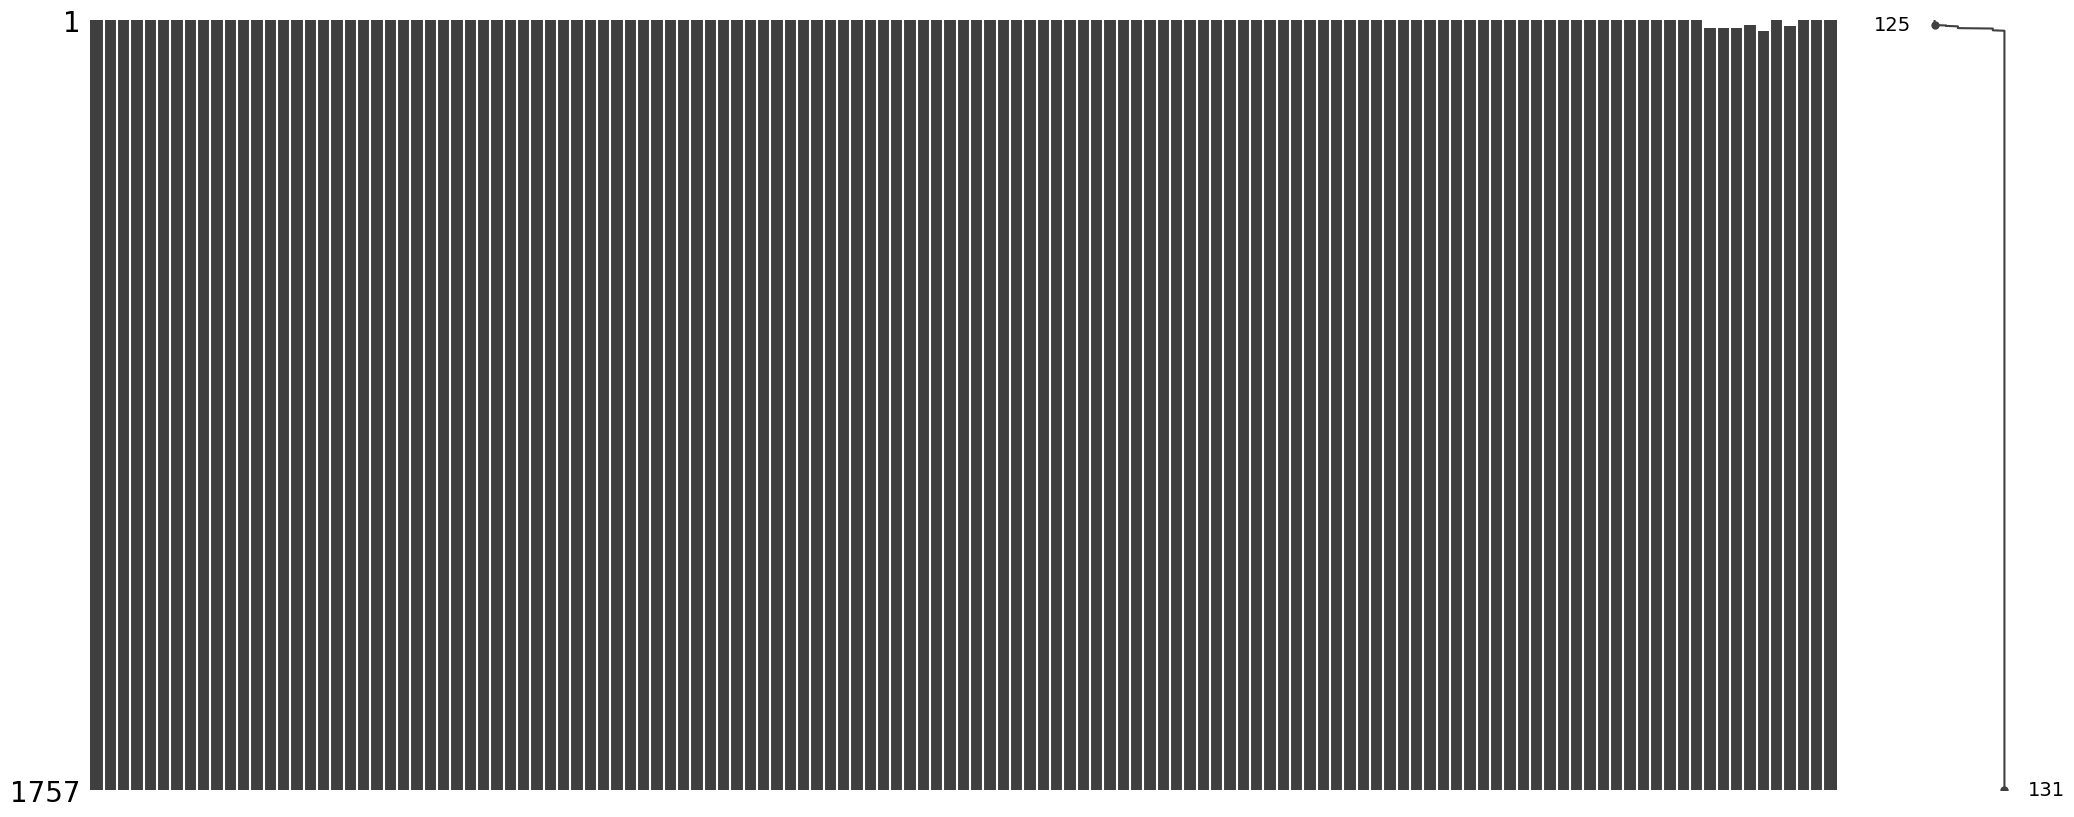

In [112]:
msno.matrix(df_technical)

In [113]:
df_technical = df_technical.dropna()

In [ ]:
# Print the number of inf and NaN values in each column before proceeding
print("Number of inf and NaN in each column:")
for col in df_technical.columns:
    num_inf = np.isinf(df_technical[col]).sum()
    num_nan = df_technical[col].isna().sum()
    print(f"{col}: inf = {num_inf}, NaN = {num_nan}")

Number of inf and NaN in each column:
date: inf = 0, NaN = 0
eurusd_close: inf = 0, NaN = 0
eurusd_open: inf = 0, NaN = 0
eurusd_high: inf = 0, NaN = 0
eurusd_low: inf = 0, NaN = 0
sp500: inf = 0, NaN = 0
euro_stoxx_600: inf = 0, NaN = 0
dax: inf = 0, NaN = 0
SOFR: inf = 0, NaN = 0
ester: inf = 0, NaN = 0
BEIR_10Y_US: inf = 0, NaN = 0
BEIR_10Y_EU: inf = 0, NaN = 0
DGS10: inf = 0, NaN = 0
DGS3MO: inf = 0, NaN = 0
EURO_IR_3MO: inf = 0, NaN = 0
EURO_IR_10Y: inf = 0, NaN = 0
return_eurousd: inf = 0, NaN = 0
return_sp500: inf = 0, NaN = 0
return_dax: inf = 0, NaN = 0
Spread_rate: inf = 0, NaN = 0
Spread_inflation: inf = 0, NaN = 0
return_sofr: inf = 0, NaN = 0
return_ester: inf = 0, NaN = 0
return_BEIR_10Y_US: inf = 0, NaN = 0
return_BEIR_10Y_EU: inf = 0, NaN = 0
return_DGS10: inf = 0, NaN = 0
return_DGS3MO: inf = 0, NaN = 0
return_EURO_IR_3MO: inf = 0, NaN = 0
return_EURO_IR_10Y: inf = 0, NaN = 0
return_Spread_rate: inf = 0, NaN = 0
return_Spread_inflation: inf = 0, NaN = 0
historical_vola

## Feature selection using RFECV

Selecting features via RFECV...
Exécution de RFECV pour sélectionner les meilleures caractéristiques...
Fitting estimator with 129 features.
Fitting estimator with 129 features.
Fitting estimator with 129 features.
Fitting estimator with 129 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 127 features.
Fitting estimator with 127 features.
Fitting estimator with 127 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 126 features.
Fitting estimator with 126 features.
Fitting estimator with 126 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 125 features.
Fitting estimator with 125 features.
Fitting estimator with 125 features.
Fitting 

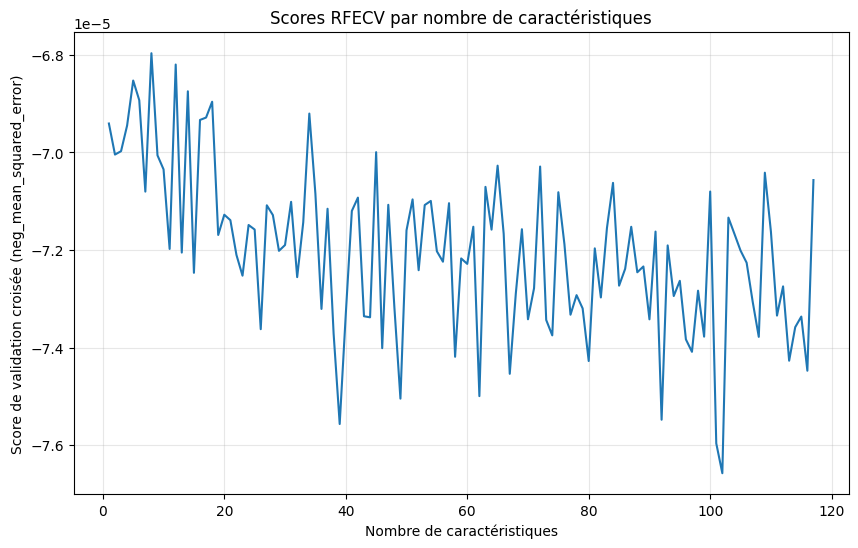

In [ ]:
# Apply feature selection with RFECV
print("Selecting features via RFECV...")
df_final, selected_features = select_features_with_rfecv(
    df_technical,
    target_col='historical_volatility',
    train_ratio=0.7,
    val_ratio=0.15,
    date_col='date',
    step=1,
    min_features=13
)


In [ ]:
# Drop date column 
df_final = df_final.drop(columns="date", errors='ignore')

## Model: LSTM and GRU

In [ ]:
# Define features excluding historical_volatility 
feature_cols = [col for col in df_final.columns if col != 'historical_volatility']

# Prepare data
X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y = prepare_time_series_data(
    df_final, 
    feature_cols=feature_cols,  
    target_col='historical_volatility', 
    n_past=30,
    n_future=1, 
    stride=1,
    train_ratio=0.7, 
    val_ratio=0.15, 
    scale_data=True,
)


Data shapes:
X_train: (1192, 30, 20), y_train: (1192, 1)
X_val: (255, 30, 20), y_val: (255, 1)
X_test: (256, 30, 20), y_test: (256, 1)


Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.1627 - mae: 0.3023 - val_loss: 0.0421 - val_mae: 0.0975 - learning_rate: 5.0000e-04
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.1756 - mae: 0.3176 - val_loss: 0.0338 - val_mae: 0.0612 - learning_rate: 5.0000e-04
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0485 - mae: 0.1068 - val_loss: 0.0511 - val_mae: 0.1332 - learning_rate: 5.0000e-04
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0573 - mae: 0.1371 - val_loss: 0.0675 - val_mae: 0.1804 - learning_rate: 5.0000e-04
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0532 - mae: 0.1245 - val_loss: 0.0948 - val_mae: 0.2490 - learning_rate: 5.0000e-04
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0365 - mae: 0.0774 - val_loss: 0.0394 - val_mae: 0.0990 - learning_rate: 5.0000e-04
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0333 - mae: 0.0622 - val_loss: 0.0336 - val_mae: 0.072

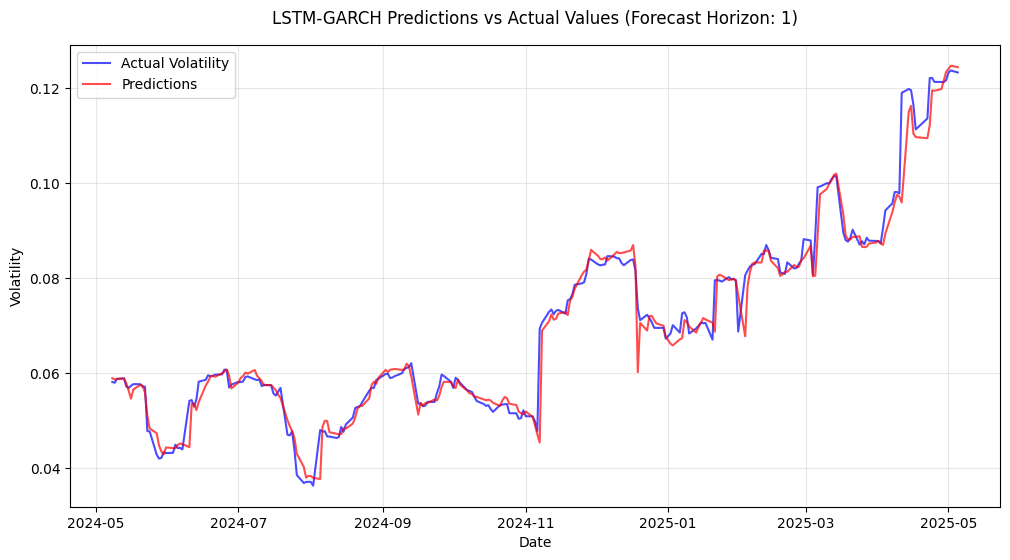

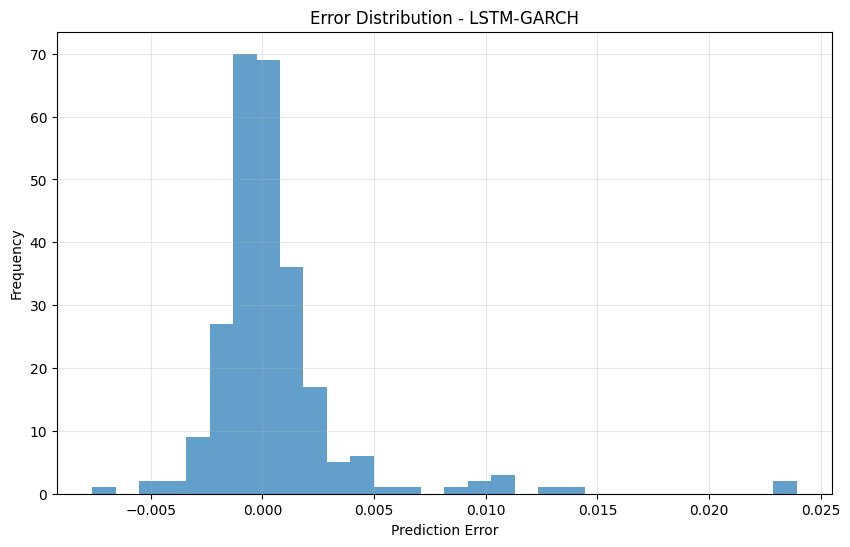

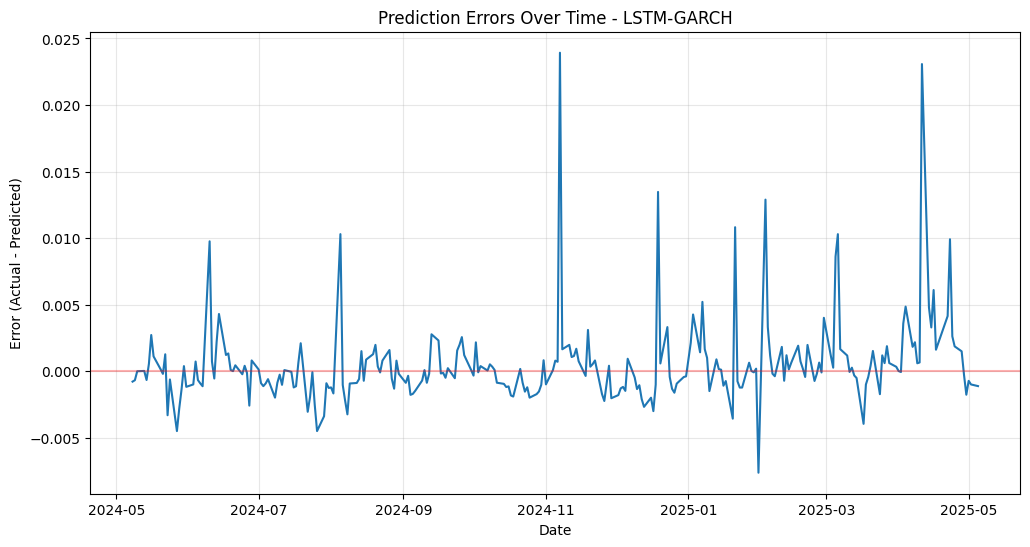

In [ ]:
# Train the LSTM model 
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_lstm_tuned_model(input_shape)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1
)

history = lstm_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    shuffle=False
)

# Evaluate the model
lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

lstm_mae, lstm_mse = evaluate_and_visualize_model(
    y_test_unscaled, 
    lstm_predictions, 
    model_name="LSTM-GARCH", 
    forecast_horizon=1,
    dates=df_technical['date'].iloc[-len(y_test):]
)

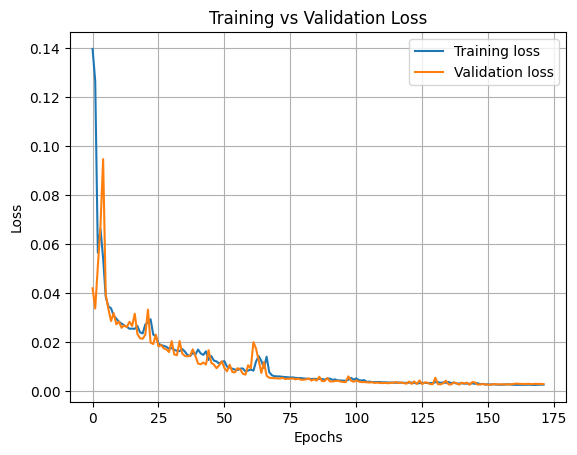

In [ ]:
# Plot training and validation loss to visualize training progress

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.1812 - mae: 0.3075 - val_loss: 0.0346 - val_mae: 0.0587 - learning_rate: 5.0000e-04
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1884 - mae: 0.3329 - val_loss: 0.2599 - val_mae: 0.4712 - learning_rate: 5.0000e-04
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.5844 - mae: 0.6001 - val_loss: 0.2050 - val_mae: 0.3967 - learning_rate: 5.0000e-04
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.2073 - mae: 0.3595 - val_loss: 0.0546 - val_mae: 0.1434 - learning_rate: 5.0000e-04
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0627 - mae: 0.1450 - val_loss: 0.0340 - val_mae: 0.0702 - learning_rate: 5.0000e-04
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0401 - mae: 0.0884 - val_loss: 0.0359 - val_mae: 0.0826 - learning_rate: 5.0000e-04
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0340 - mae: 0.0679 - val_loss: 0.0331 - val_mae: 0.07

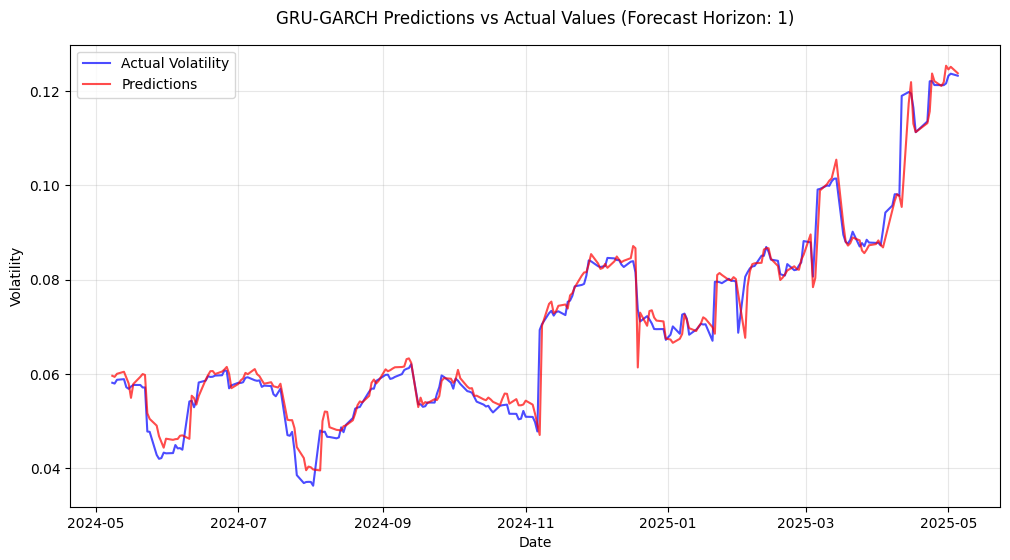

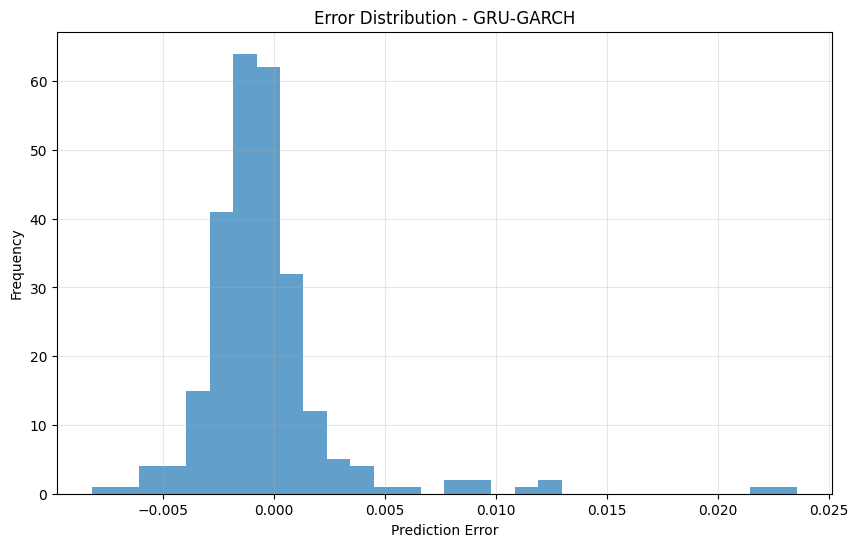

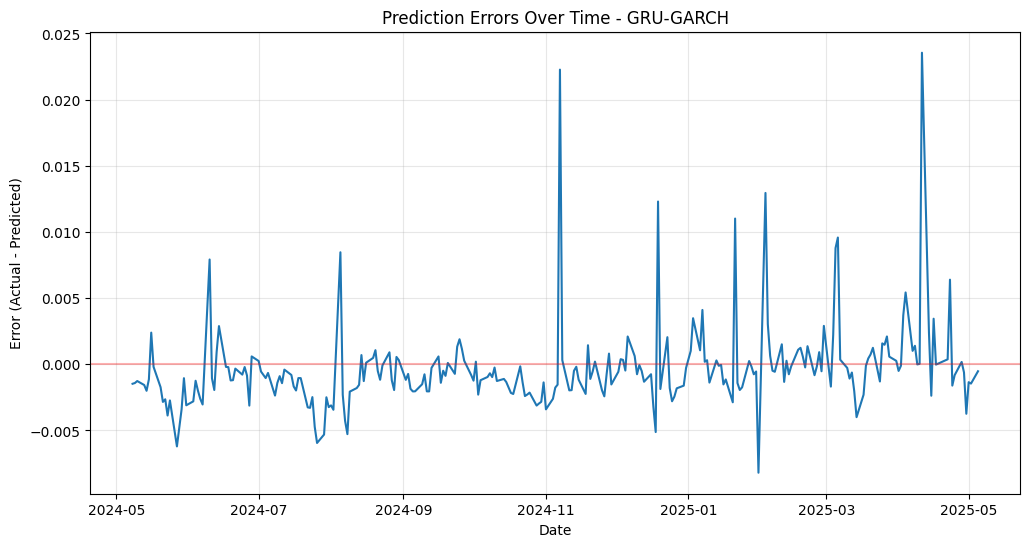

In [ ]:
# Train the GRU model
input_shape = (X_train.shape[1], X_train.shape[2])
gru_model = create_gru_model(input_shape)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1
)

history = gru_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    shuffle=False
)

# Evaluate the model
gru_predictions_scaled = gru_model.predict(X_test)
gru_predictions = scaler_y.inverse_transform(gru_predictions_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

gru_mae, gru_mse= evaluate_and_visualize_model(
    y_test_unscaled,
    gru_predictions,
    model_name="GRU-GARCH",
    forecast_horizon=1,
    dates = df_technical['date'].iloc[-len(y_test):]
)

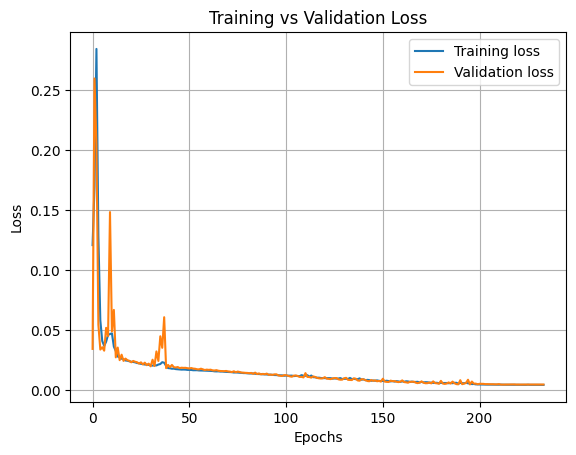

In [ ]:
# Plot training and validation loss to visualize training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()